# CNN + LSTM ile RF Sinyal Modülasyon Sınıflandırması (RadioML 2018.01A)
Derin öğrenme ile kablosuz iletişim sinyallerinin doğru ve hızlı sınıflandırılması


## 📖 Giriş

Kablosuz iletişim sistemlerinde, alınan sinyallerin hangi modülasyon tekniğiyle gönderildiğini tespit etmek çok önemlidir. Bu projede, **RadioML 2018.01A** veri setinden seçilen 8 modülasyon sınıfını sınıflandırmak için **CNN + LSTM tabanlı bir derin öğrenme modeli** kullanılmıştır.

Amaç, I/Q (In-phase/Quadrature) örneklerinden uzamsal ve zamansal özellikleri çıkararak yüksek doğrulukta sınıflandırma yapmaktır.

> Sonuç: Model test verisinde **%90.66 doğruluk** elde etmiştir.


## 🧠 Yaklaşım

- **Veri Seti**: RadioML 2018.01A
- **Seçilen Sınıflar**: 8 farklı modülasyon türü (BPSK, 16QAM, FM, AM-DSB-WC vb.)
- **Model Mimarisi**:
  - I ve Q bileşenleri için ayrı CNN dalları
  - Özelliklerin birleştirilip LSTM’e verilmesi
  - Fully-connected katmanlar ve dropout ile düzenleme
- **Kayıp Fonksiyonu**: Categorical Crossentropy
- **Optimizasyon**: Adam (lr=0.0001)
- **Başarı Ölçütü**: Doğruluk (Accuracy)


## 🧪 Veri Ön İşleme

- Her modülasyon sınıfında toplam 106,496 örnek bulunmakta.
- Veri setinden yalnızca **düşük SNR seviyelerini** temsil eden 4.096 x 4 örnek seçilmiştir.
- Veriler (1024,) formatından (32, 32, 2) şekline getirilerek 2D CNN'e uygun hale getirilmiştir.
- Etiketler one-hot encoding formatına dönüştürülmüştür.


## 🧱 Model Mimarisi

Model şu yapılardan oluşur:
- I ve Q sinyalleri için ayrı **2D CNN dalları**
- Uzamsal özelliklerin birleştirilmesi ve **LSTM**'e aktarılması
- **Tam bağlantılı (Dense) katmanlar** ve **dropout** ile genelleme kabiliyetinin artırılması
- Çıkışta softmax ile 8 sınıf tahmini yapılır

✅ Sonuç: Test doğruluğu **%90.66**


In [1]:
# gerekli kutuphanelerin yuklenmesi
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
import tensorflow.keras as tk
from keras.layers import ReLU


2025-07-09 05:37:18.730439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752039438.912871      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752039438.968724      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# veri dosyasini HDF5 formatinda acma islemi
file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5", "r")

# siniflar
all_classes = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
               '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
               '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
               'FM', 'GMSK', 'OQPSK']

# sinyal tipi çeşitliliği açısından dengeli olacak sekilde bu siniflardan bazilarini seciyoruz
chosen_classes = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK']
class_indices = [all_classes.index(cls) for cls in chosen_classes]


In [3]:
# tum siniflardan belirli sayida ornek aliyoruz
features, labels = [], []
snr_count = 4

for class_id in class_indices:
    start = (106496 * (class_id + 1)) - 4096 * snr_count
    end = 106496 * (class_id + 1)
    features.append(file['X'][start:end])
    labels.append(file['Y'][start:end])

# dizi haline getirip sekillendiriyoruz
X = np.concatenate(features).reshape(-1, 32, 32, 2)
Y_raw = np.concatenate(labels)
Y_df = pd.DataFrame(Y_raw)

# sadece secili siniflar kaliyor
non_zero_cols = Y_df.columns[Y_df.sum() > 0]
Y_df = Y_df[non_zero_cols]
Y_df.columns = chosen_classes


In [4]:
# egitim ve test kumeleri
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_df, test_size=0.2, random_state=42)


In [5]:
# CNN + LSTM Modeli
def build_model():
    input_i = keras.Input(shape=(32, 32, 1))
    input_q = keras.Input(shape=(32, 32, 1))
    
    def cnn_branch(input_layer):
        x = tk.layers.Conv2D(48, 3, activation=ReLU())(input_layer)
        x = tk.layers.Conv2D(48, 3, activation=ReLU())(x)
        x = tk.layers.MaxPool2D(pool_size=2)(x)
        x = tk.layers.Conv2D(96, 3, activation=ReLU())(x)
        x = tk.layers.Conv2D(96, 3, activation=ReLU())(x)
        x = tk.layers.MaxPool2D(pool_size=2)(x)
        return tk.layers.Flatten()(x)

    branch_i = cnn_branch(input_i)
    branch_q = cnn_branch(input_q)
    merged = keras.layers.Concatenate()([branch_i, branch_q])

    lstm_input = keras.layers.Reshape((1, -1))(merged)
    lstm_output = tk.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(lstm_input)

    x = tk.layers.Dense(512, activation=ReLU())(lstm_output)
    x = tk.layers.Dropout(0.4)(x)
    x = tk.layers.Dense(256, activation=ReLU())(x)
    x = tk.layers.Dropout(0.4)(x)

    output = tk.layers.Dense(len(chosen_classes), activation='softmax')(x)

    model = keras.Model(inputs=[input_i, input_q], outputs=output)
    model.compile(optimizer=tk.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()


I0000 00:00:1752039640.333625      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752039640.334383      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# egitim sirasinda erken durdurma ve model kaydetme
callbacks = [
    tk.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tk.callbacks.ModelCheckpoint("best_model_rf.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

history = model.fit(
    [X_train[:,:,:,0], X_train[:,:,:,1]],
    Y_train,
    validation_data=([X_test[:,:,:,0], X_test[:,:,:,1]], Y_test),
    batch_size=64,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/25


I0000 00:00:1752039672.782525     102 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_loss improved from inf to 0.79405, saving model to best_model_rf.weights.h5
1639/1639 - 45s - 28ms/step - accuracy: 0.5744 - loss: 0.9020 - val_accuracy: 0.6015 - val_loss: 0.7941
Epoch 2/25

Epoch 2: val_loss improved from 0.79405 to 0.77420, saving model to best_model_rf.weights.h5
1639/1639 - 32s - 20ms/step - accuracy: 0.6029 - loss: 0.8003 - val_accuracy: 0.6093 - val_loss: 0.7742
Epoch 3/25

Epoch 3: val_loss improved from 0.77420 to 0.50139, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.6755 - loss: 0.6781 - val_accuracy: 0.7760 - val_loss: 0.5014
Epoch 4/25

Epoch 4: val_loss improved from 0.50139 to 0.46845, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.7755 - loss: 0.5070 - val_accuracy: 0.7924 - val_loss: 0.4685
Epoch 5/25

Epoch 5: val_loss improved from 0.46845 to 0.44577, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.7907 - loss: 0.4757 - val_accura

## 📈 Eğitim Sonuçları

Eğitim süreci boyunca:
- Doğruluk ve kayıp değerleri takip edildi
- Aşırı öğrenmeyi engellemek için **early stopping** ve **model checkpoint** kullanıldı

Aşağıda eğitim sonuçlarına ait grafikler yer almaktadır.


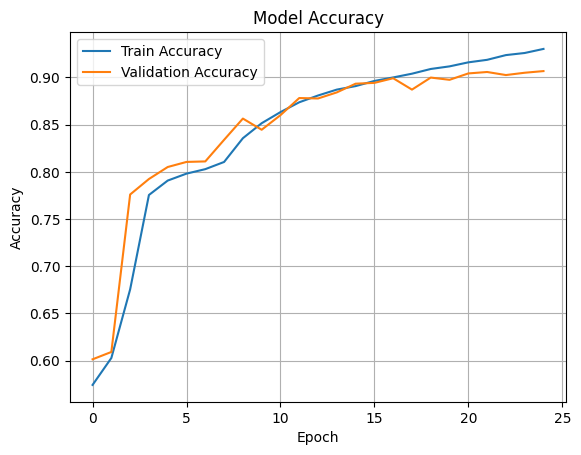

In [7]:
# dogruluk
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


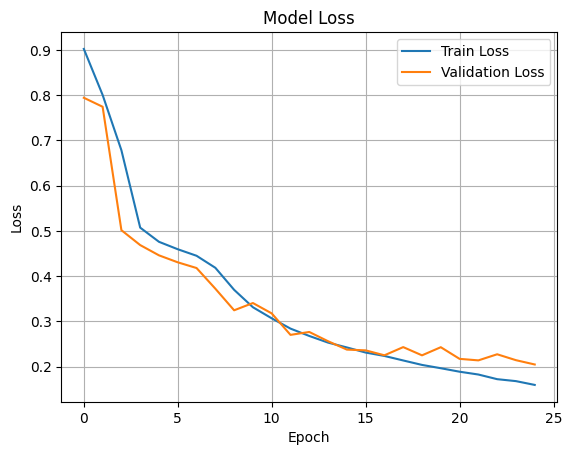

In [8]:
# kayip (Loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()


## 🔍 Karmaşıklık Matrisi

Aşağıdaki matriste modelin hangi modülasyon sınıflarını ne kadar doğru tahmin ettiği gösterilmektedir.

Bazı benzer modülasyonlar (örneğin AM ve FM) arasında karışıklık olması doğaldır. Buna rağmen genel sınıflandırma başarımı oldukça yüksek seviyededir.

Bu tür analizler özellikle:
- Askeri haberleşme sistemlerinde
- Spektrum izleme çözümlerinde
- Otonom sinyal tanımlayıcılarda önemlidir.


820/820 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


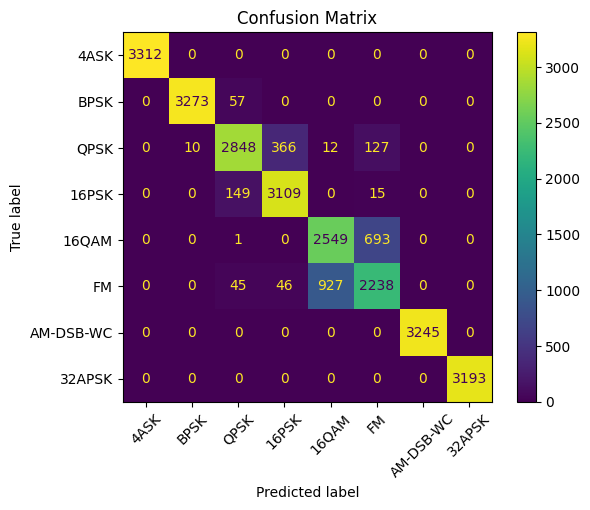

In [9]:
# tahmin ve sinif eslesmeleri
pred_probs = model.predict([X_test[:,:,:,0], X_test[:,:,:,1]])
y_true = np.argmax(Y_test.values, axis=1)
y_pred = np.argmax(pred_probs, axis=1)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=chosen_classes).plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False); plt.show()


In [10]:
# agirliklari kaydediyoruz
model.save_weights('/kaggle/working/custom_rf_model.weights.h5')


In [11]:
# agirliklari geri yükleyip test ediyoruz
restored_model = build_model()
restored_model.load_weights('/kaggle/working/custom_rf_model.weights.h5')
loss, acc = restored_model.evaluate([X_test[:,:,:,0], X_test[:,:,:,1]], Y_test, verbose=0)
print(f"Yüklenen model doğruluğu: %{acc*100:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Yüklenen model doğruluğu: %90.66


## 💬 Sonuç ve Gelecek Çalışmalar

Bu proje, RF sinyallerinin sınıflandırılmasında derin öğrenmenin gücünü göstermektedir. CNN + LSTM tabanlı modelimiz, düşük SNR koşullarında dahi yüksek doğruluk sağlamıştır.

### Geliştirme Fikirleri:
- 24 modülasyon sınıfının tamamını dahil etmek
- Transformer tabanlı alternatif yapıları denemek
- Gerçek zamanlı gömülü sistemlere (Jetson, FPGA) entegrasyon

### Uygulama Alanları:
- Akıllı spektrum yönetimi
- SDR cihazlarıyla sinyal analiz
- Jamming tespiti ve engelleme


## 🔗 Kaynaklar

- RadioML 2018.01A: (https://www.kaggle.com/datasets/pinxau1000/radioml2018/data)
- O’Shea, T. J., Roy, T., Clancy, T. C. – Over-the-air Deep Learning for Modulation Classification
